---
title: "Building Time-series Utilities for `matplotlib`"
bibliography: "../../blog.bib"
author: "Peter Amerkhanian"
date: "2024-6-16"
draft: false
categories: ['Python']
format:
  html:
    toc: true
    toc-depth: 3
    code-fold: false
    code-tools: true
---

In my day job I've recently been working on visualizing time series data with `matplotlib`. When I've wanted some sort of specific formatting or behavior, I've had to wade deep in the library documentation to figure out the code for the things I want to do. That's fine, but what frustrates me is that in the back of my mind, I'm pretty sure these are all things I've actually done before. A few years ago in graduate school I took a course that was heavy on `matplotlib` plotting, and I spent many hours figuring out bizarre techniques for getting very specific results. Unfortunately I've forgotten almost all of that library-specific minutiae.  

This has led me to a new project -- I'm creating a personal data science utilities library with modules for `matplotlib`/`seaborn`, `pandas`, `geopandas`, and `scikit-learn`, each containing functions that do all the random things I've repeatedly built custom code solutions for in the past. The hope is that I don't need to keep re-learning the same things and can call simple wrapper functions that I've written.

In this post, I'm going to cover a few `matplotlib` extensions that I often need. I'll cover:  

- Formatting y-axis strings into whole numbers with commas
- Moving a legend outside of the axis
- Reusing a colormap in `seaborn` so that the same classes correspond to the same colors across various visualizations
- Grid plots

In [572]:
import pandas as pd
import numpy as np
import dask.dataframe as dd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.ticker as ticker
plt.style.use('default')
from datetime import datetime
from typing import Tuple, Union
from collections.abc import Iterable

I'll be using the BART dataset that I created in [my blog post on `dask`](../dask-data-io/index.ipynb).

In [573]:
df = dd.read_parquet("../dask-data-io/data/parquet_data")
df.head()


,Date,Hour,Start,End,Riders
0,2011-01-01,0,12TH,16TH,1
1,2011-01-01,0,12TH,24TH,3
2,2011-01-01,0,12TH,ASHB,2
3,2011-01-01,0,12TH,BAYF,5
4,2011-01-01,0,12TH,CIVC,3


Let's say I'm interested specifically in an aggregate time series with the number of riders that used the system, for each hour from 2011-2024. I'll do the appropriate grouping to build that dataset and move from `dask` to `pandas`.

In [574]:
df_rph = df.groupby(['Date', 'Hour'])['Riders'].sum().compute()
df_rph = df_rph.reset_index()
df_rph.head()


,Date,Hour,Riders
0,2011-01-01,0,5174
1,2011-01-01,1,15479
2,2011-01-01,2,11055
3,2011-01-01,3,5592
4,2011-01-01,4,795


I'm going to be doing a lot of slicing on the date, and I find that it's easiest to do that when the date column is a datetime index. Also, since I'll do some analysis of months of data, I'm going to truncate the time series to the last full month.

In [575]:
df_rph['Date'] = pd.to_datetime(df_rph['Date'], format="%Y-%m-%d")
df_rph_d = df_rph.set_index("Date")
df_rph_d = df_rph_d.loc[:"2024-04-30"]
df_rph_d.head()


,Hour,Riders
Date,,
2011-01-01,0,5174
2011-01-01,1,15479
2011-01-01,2,11055
2011-01-01,3,5592
2011-01-01,4,795


For now I'll sum over the hours and just examine ride totals per day in a `pd.Series`

In [576]:
month_time_series = df_rph_d.resample("ME")['Riders'].sum()
month_time_series.head()


Date
2011-01-31    8203562
2011-02-28    7933264
2011-03-31    9049039
2011-04-30    8824840
2011-05-31    8940380
Freq: ME, Name: Riders, dtype: int64

Simply plotting the series shows the impact of the pandemic, which is interesting:

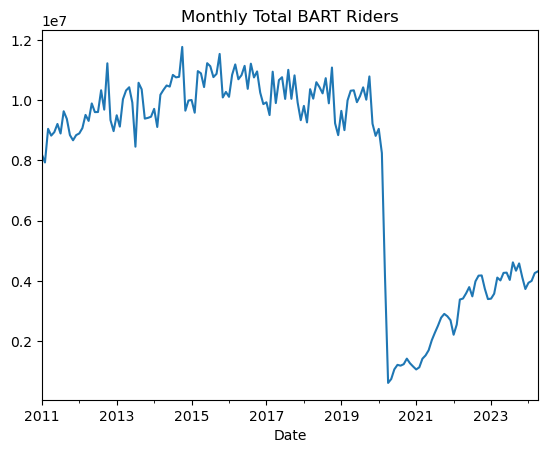

In [590]:
month_time_series.plot()
plt.title("Monthly Total BART Riders");

## Pandemic Impact

I might want to do a slightly more dynamic plot of the pandemic's impact, where I more directly show how this drop in ridership compared to typical ridership.

To create this more complex visual, I'll create a suite of functions:  

- `time_overlay_plot`, which creates an overlay plot where the x-axis represents months and each series corresponds to a year of data.
- `show_all_xticks`, which overrides default matplotlib x-tick behavior and shows all possible ticks
-  `custom_legend`, which will make it easier to move a legend outside of the plot area

In [578]:
# | code-fold: true

def time_overlay_plot(month_time_series: pd.Series,
                      ax: matplotlib.axes.Axes,
                      step_size: int,
                      highlight_year: int,
                      date_formatter: str,
                      bg_alpha: float = .3) -> Tuple[matplotlib.axes.Axes, pd.Index]:
    """
    Create an overlay plot where the x-axis represents months and each series corresponds to a year of data.

    This function reads in a month-level time series with data spanning multiple years. It overlays the data for each year 
    on the same plot, allowing for year-over-year comparison. One year can be highlighted for emphasis.

    Args:
        month_time_series (pd.Series): A time series with observations at one-month intervals.
        ax (matplotlib.axes.Axes): A Matplotlib axis object to plot on.
        step_size (int): The number of years to skip between plotted series.
        highlight_year (int): The year to highlight in the overlay plot. Set to None for no highlight.
        date_formatter (str): The format string for the date labels on the x-axis.
        bg_alpha (float): The alpha transparency for the non-highlighted lines. Defaults to 0.3.

    Returns:
        matplotlib.axes.Axes: The updated axis object with the overlay plot.
        pd.Index: The x-tick labels of the plot.

    Raises:
        AssertionError: If step_size is larger than the number of unique years in the time series.
    """
    target_years = month_time_series.index.year.unique()[::step_size]
    assert (len(target_years) > step_size), "Step size larger than index length"
    labs = month_time_series.loc[str(
        target_years[-step_size]):str(target_years[-1])].index.strftime(date_formatter)
    for i in range(len(target_years)-(step_size-1)):
        a = 1 if (target_years[i + (step_size-1)]
                  == highlight_year) else bg_alpha
        subset_time_series = (
            month_time_series
            .loc[str(target_years[i]): str(target_years[i + (step_size-1)])]
            .reset_index()
            .set_index(labs)[month_time_series.name]
        )
        label = fr"${target_years[i]} \rightarrow {target_years[i + (step_size-1)]}$" if step_size != 1 else fr"${target_years[i]}$"
        subset_time_series.plot(linewidth=3,
                                ax=ax,
                                alpha=a,
                                label=label)
    return ax, labs


def show_all_xticks(ax: matplotlib.axes.Axes, labs: pd.Index) -> matplotlib.axes.Axes:
    """
    Sets all x-ticks on a Matplotlib axis object and labels them with the provided list of labels.

    This function ensures that all x-ticks are displayed and labeled as specified, making it easier to read and interpret the x-axis of the plot. The labels are displayed horizontally.

    Parameters:
    ax (matplotlib.axes.Axes): The axis object on which to set the x-ticks and labels.
    labs (list of str): A list of labels to set on the x-axis. The number of labels should correspond to the number of ticks.

    Returns:
    matplotlib.axes.Axes: The modified axis object with updated x-ticks and labels.
    """
    ax.set_xticks(range(len(labs)))
    ax.set_xticklabels(labs, rotation=0)
    return ax


def comma_formatter() -> ticker.FuncFormatter:
    """
    Creates a custom Matplotlib tick formatter that formats axis ticks with commas.

    This formatter converts axis tick values to integers and formats them with commas for thousands 
    separators. This can be useful for improving the readability of plots with large numerical values.

    Returns:
    --------
    ticker.FuncFormatter:
        A Matplotlib FuncFormatter object that applies the comma formatting to axis ticks.
    """
    def comma(x: float, pos) -> str:
        """Format the tick value `x` with commas. The parameter `pos` is not used."""
        return '{:,}'.format(int(x))

    return ticker.FuncFormatter(comma)


def custom_legend(ax: matplotlib.axes.Axes,
                  outside_loc: str = None,
                  order: Union[str, list] = "default",
                  title: str = "",
                  linewidth: int = 2,
                  **kwargs) -> matplotlib.axes.Axes:
    """
    Customize the legend location and order on a Matplotlib axis.

    This function adjusts the position of the legend, optionally placing it outside the plot area,
    and can reorder the legend entries based on specified criteria.

    Args:
        ax (matplotlib.axes.Axes): An existing Matplotlib axis object to which the legend belongs.
        outside_loc (str, optional): Specifies the location of the legend outside the plot area.
                                     Must be one of ["lower", "center", "upper", None]. 
                                     Defaults to None.
        order (str, optional): Determines the order of the legend entries. 
                               Must be one of ["default", "reverse", "desc"]. 
                               "default" keeps the current order, 
                               "reverse" reverses the current order, 
                               "desc" orders entries by descending values. 
                               Defaults to "default".

    Returns:
        matplotlib.axes.Axes: The axis object with the customized legend.

    Raises:
        AssertionError: If `outside_loc` is not in ["lower", "center", "upper", None].
    """
    handles, labels = ax.get_legend_handles_labels()
    if order == 'default':
        pass
    elif order == 'reverse':
        handles = handles[::-1]
        labels = labels[::-1]
    elif order == 'desc':
        ordering = np.flip(np.argsort(np.array([line.get_ydata()[-1] for line in ax.lines if len(line.get_ydata())>0])))
        handles = np.array(handles)[ordering].tolist()
        labels = np.array(labels)[ordering].tolist()
    elif isinstance(order, Iterable):
        value_to_index = {value: idx for idx, value in enumerate(labels)}
        indices = [value_to_index[value] for value in order]
        labels = list(order)
        handles = np.array(handles)[indices].tolist()
    else:
        raise Exception("Invalid Order")
    error_msg = "legend_to_right loc must be None or in 'lower', 'center', or 'upper'"
    assert outside_loc in ["lower", "center", "upper", None], error_msg
    if outside_loc == "lower":
        ax.legend(handles, labels, loc='lower left', bbox_to_anchor=(1, 0), **kwargs)
    elif outside_loc == "center":
        ax.legend(handles, labels, loc='center left', bbox_to_anchor=(1, .5), **kwargs)
    elif outside_loc == "upper":
        ax.legend(handles, labels, loc='upper left', bbox_to_anchor=(1, 1), **kwargs)
    else:
        ax.legend(handles, labels, **kwargs)
    legend = ax.get_legend()
    legend.set_title(title)
    for line in legend.get_lines():
        line.set_linewidth(linewidth)
    return ax


Using these functions, I'll create a time series overlay that shows the impact of the pandemic on BART ridership in the context of previous three year trends, e.g. how does 2019-2021 compare to 2015-17? The effect is a plot that suggests that monthly BART ridership was on a trajectory similar to previous years leading up to the pandemic before sharply departing.

Note that I'm able to flexibly define the date formatting for the x-axis using a `date_formatter` argument, and I can select to highlight a particular year with the `highlight_year` argument.

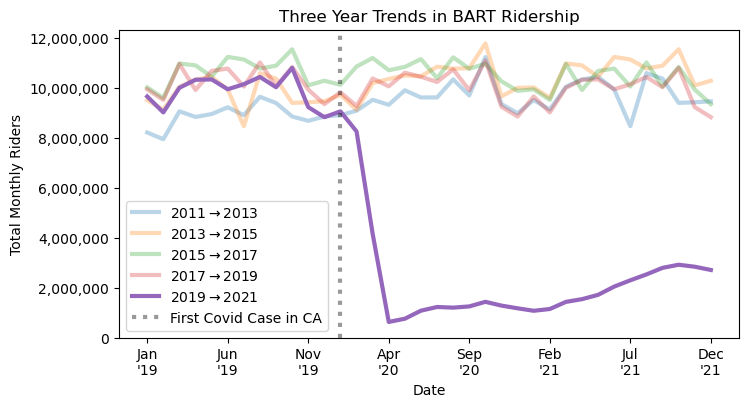

In [579]:
fig, ax = plt.subplots(figsize=(8, 4))
date_formatter = '%b\n\'%y'
_, labs = time_overlay_plot(month_time_series.loc["2011":"2021"],
                            ax=ax, step_size=2,
                            highlight_year=2021,
                            date_formatter=date_formatter)
ax.yaxis.set_major_formatter(comma_formatter())
ax.set(ylim=0, title="Three Year Trends in BART Ridership",
       ylabel="Total Monthly Riders")
ax.axvline(np.where(labs == datetime(2020, 1, 1).strftime(date_formatter)),
           linestyle=":",
           label="First Covid Case in CA",
           color="black",
           linewidth=3,
           alpha=.4)
ax.legend();


I'll use the same `time_overlay_plot` function to examine the recovery of the BART system in the post-pandemic period. This time, I'll also use `custom_legend` to easily move the legend outside of the plot area.

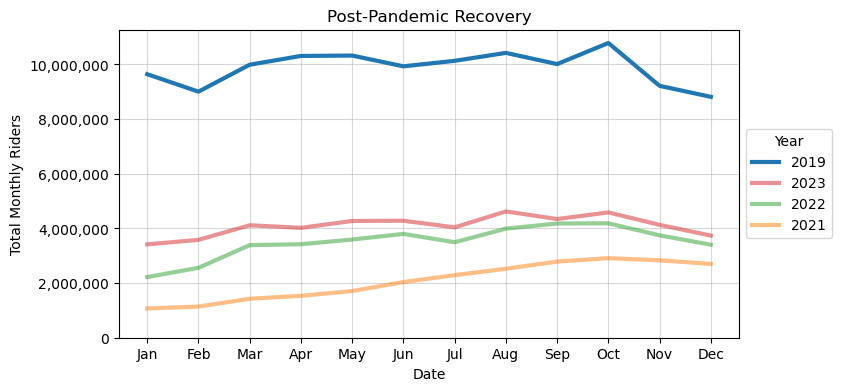

In [580]:
month_time_series_trunc = pd.concat(
    [df_rph_d.resample("ME")['Riders'].sum().loc["2019-01-01": "2020-01-01"],
     df_rph_d.resample("ME")['Riders'].sum().loc["2021-01-01": "2024-01-01"]])

fig, ax = plt.subplots(figsize=(8, 4))
date_formatter = '%b'
_, labs = time_overlay_plot(month_time_series_trunc, ax=ax, step_size=1,
                            highlight_year=2019, date_formatter=date_formatter, bg_alpha=.5)
show_all_xticks(ax, labs)
ax.yaxis.set_major_formatter(comma_formatter())
ax.set(ylim=0, title="Post-Pandemic Recovery", ylabel="Total Monthly Riders")
ax.grid(alpha=.5)
custom_legend(ax, outside_loc="center", order="desc",
              title="Year", linewidth=3)
handles, labels = ax.get_legend_handles_labels()


## Commute Patterns
I'll now move onto examining some commute patterns. Here I'll create some custom functions for building a colormap that I can use to consistently denote color-class relationships across multiple plots. Default behavior in `matplotlib` and `seaborn` typically leads to color-class relationships changing across charts of different types or involving different subsets of the data, e.g. in Chart 1, class A is Red, but in Chart 2, class A is Blue. My custom function, `build_colormap`, creates a simple color-class relationship dictionary that defines the color-class relationships once and can be input to various `seaborn` visuals.  

I'll define color-class relationships for the days of the week, but first I'll do some setup in `pandas`

In [581]:
df_rph['day_of_week'] = df_rph['Date'].dt.day_name()
df_rph['Weekend'] = df_rph['day_of_week'].isin(['Saturday', 'Sunday'])
df_rph['Hour_12'] = pd.to_datetime(
    df_rph['Hour'], format='%H').dt.strftime('%I:%M %p')
df_rph['Hour_12'] = df_rph['Hour_12'].str.replace(":00 ", "\n").str.strip("0")
df_rph['Rider_Thousands'] = df_rph['Riders'] / 1000


Now I'll define the `build_colormap` function and create my color mapping

In [582]:
# | code-fold: true

def build_colormap(series: pd.Series) -> dict:
    """
    Build a colormap dictionary for a pandas Series.

    This function creates a dictionary that maps each unique value in the input
    Series to a unique color from the 'tab10' colormap provided by Seaborn. The 
    function ensures that the number of unique values in the Series is less than 10.

    Parameters:
    ----------
    series : pd.Series
        The pandas Series for which to build the colormap. Each unique value in the 
        Series will be assigned a unique color.

    Returns:
    -------
    dict
        A dictionary where the keys are the unique values from the input Series 
        and the values are the corresponding colors from the 'tab10' colormap.

    Raises:
    ------
    AssertionError
        If the number of unique values in the Series is 10 or more.
    """
    unique_set = series.unique()
    assert len(unique_set) < 10
    colors = sns.color_palette("tab10")
    colormap = {}
    for d, c in zip(unique_set, colors[:len(unique_set)]):
        colormap[d] = c
    return colormap


Here is the resulting color-mapping dictionary

In [583]:
colormap = build_colormap(df_rph['day_of_week'])
colormap


{'Saturday': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 'Sunday': (1.0, 0.4980392156862745, 0.054901960784313725),
 'Monday': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 'Tuesday': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 'Wednesday': (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 'Thursday': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 'Friday': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)}

and here's a simple application of that colormap to examine the average riders-per-hour in the BART system.

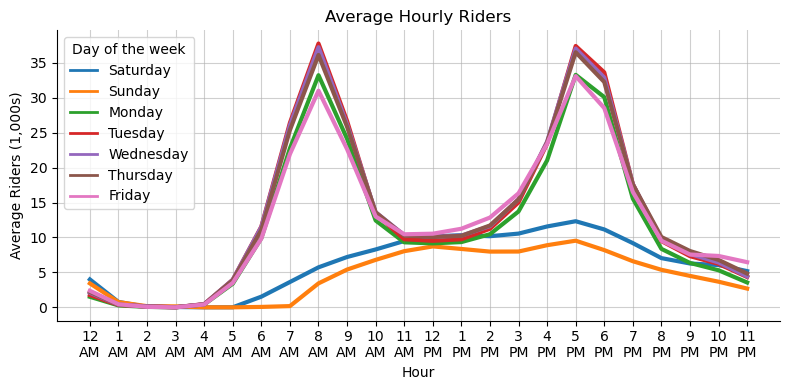

In [584]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.despine(top=True, ax=ax)
sns.lineplot(
    data=df_rph,
    x='Hour_12',
    y='Rider_Thousands',
    hue='day_of_week',
    palette=colormap,
    linewidth=3,
    estimator='mean',
    errorbar=None,
    ax=ax)
ax.set(
    title="Average Hourly Riders",
    ylabel="Average Riders (1,000s)",
    xlabel="Hour")
custom_legend(ax, title="Day of the week", linewidth=2, order=list(colormap.keys()))
ax.grid(alpha=.6)
fig.tight_layout()


I can see the degree to which BART seems to have a lot of its ridership concentrated in commute times. Now lets say that I want to reproduce this plot repeatedly for different years, so see how this general shape changes before and after the pandemic. This is going to be a grid plot, where each individual plot in the grid represents one year of data. I'll create a flexible function for grid-plotting, `grid_plot`, below, which allows for one to pass in a `seaborn` plot, and `**kwargs` for that plotting function, and repeat that plot across some grouping variable, `group_var`.

In [585]:
# | code-fold: true

def grid_plot(grid_subset: pd.DataFrame,
              seaborn_func: callable,
              rows: int,
              cols: int,
              group_var: str,
              figsize: tuple = (10, 5),
              legend_loc: str = "lower",
              **kwargs):
    facet = grid_subset[group_var].unique()
    facet = facet.reshape(rows, cols)
    fig, axes = plt.subplots(
        facet.shape[0], facet.shape[1], sharex=True, sharey=True, figsize=figsize)
    for m in range(facet.shape[0]):
        for n in range(facet.shape[1]):
            group = facet[m, n]
            subset = grid_subset[grid_subset[group_var] == group]
            if legend_loc == 'lower':
                legend = True if (m+1 == rows) and (n+1 == cols) else False
            elif legend_loc == "upper":
                legend = True if (m+1 == 1) and (n+1 == cols) else False
            else:
                legend = False
            seaborn_func(
                data=subset,
                ax=axes[m, n],
                legend=legend,
                **kwargs)
            axes[m, n].set(ylabel=None, xlabel=None, title=group)
            axes[m, n].grid()
    return fig, axes


For an application, I'll create a dataset from 2018-2024 where I want to display one chart per year in a grid pattern

In [586]:
grid_subset = df_rph.copy()[(df_rph['Date'] > "2018")
                            & (df_rph['Date'] < "2024")]
grid_subset['Year'] = grid_subset['Date'].dt.year

Now I can use my function, `grid_plot`, to specify a plot type, a grid shape, and pass `seaborn` `**kwargs` to the underlying plotting function.

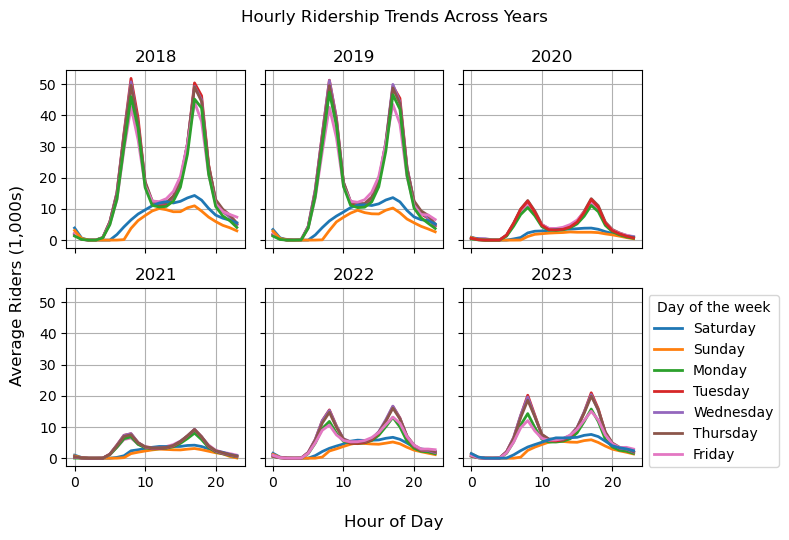

In [587]:
fig, axes = grid_plot(grid_subset,
                      sns.lineplot,
                      rows=2, cols=3,
                      group_var='Year',
                      legend_loc="lower",
                      x='Hour',
                      y='Rider_Thousands',
                      hue='day_of_week',
                      figsize=(8, 5),
                      palette=colormap,
                      estimator='mean',
                      linewidth=2,
                      errorbar=None)
custom_legend(axes[1, 2], outside_loc="upper",
              title="Day of the week", linewidth=2, order=list(colormap.keys()))
fig.supxlabel("Hour of Day")
fig.supylabel("Average Riders (1,000s)")
fig.tight_layout()
fig.suptitle("Hourly Ridership Trends Across Years", y=1.05);

The grid presents an interesting pattern in so far as the general level of ridership drops across all hours, but the raw plot seems to suggest that the gap between peak commute ridership levels and off-peak ridership seems to have shrunken post-pandemic. In late 2023, BART [instituted scheduling changes](https://www.bart.gov/news/articles/2023/news20230427) to reflect  their belief that demand has shifted in the post-pandemic towards rides outside of peak commute times.  

We can check that with a simple time series plot that relies on my `custom_legend` function to move the legend and resize the lines within it.

In [591]:
is_commute = (df_rph['Hour'].isin([7, 8, 9, 16, 17, 18, 19]) &
              ~df_rph['Weekend']).replace({
                  True: 'Riders during Peak Commute times',
                  False: 'Riders during Off-Peak times'
              })

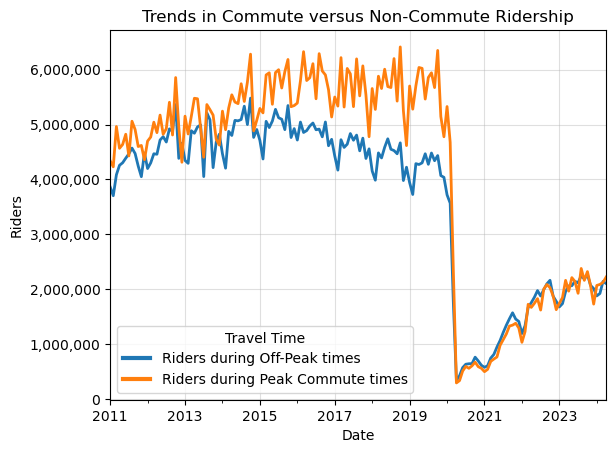

In [593]:
fig, ax = plt.subplots()
(df_rph[df_rph['Date'] < "2024-05-01"]
 .pivot_table(index=pd.Grouper(key='Date', freq='ME'),
              columns=is_commute,
              values="Riders",
              aggfunc='sum')
 ).plot(linewidth=2, ax=ax)
ax.yaxis.set_major_formatter(comma_formatter())
ax.grid(alpha=.4)
ax.set(ylabel="Riders", title="Trends in Commute versus Non-Commute Ridership")
custom_legend(ax, title="Travel Time", linewidth=3, loc="lower left");

It does look like off peak and peak commute ridership had a growing gap in the pre-pandemic, but have been essentially equal in the post pandemic, interesting!